# Graph on BFS

test script to try bulding a graph on top of the face heads

## import

In [1]:
import os
import numpy as np
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.PatternFeatureReduction import PatternFeatureSelection
from utils.ref_feature_map_neurons import ref_feature_map_neuron
from utils.calculate_position import calculate_position
from plots_utils.plot_cnn_output import plot_cnn_output
from plots_utils.plot_ft_map_pos import plot_ft_map_pos
from plots_utils.plot_ft_map_pos import plot_pos_on_images
from plots_utils.plot_tuning_signatures import plot_tuning_signatures
from models.NormBase import NormBase
from utils.patches import compute_center_of_activity

import matplotlib.pyplot as plt

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=150)

# Set parameters

In [2]:
# define configuration
config_path = 'GR_t02_graph_on_BFS_m0001.json'

# declare parameters
best_eyebrow_IoU_ft = [68, 125]
best_lips_IoU_ft = [235, 203, 68, 125, 3, 181, 197, 2, 87, 240, 6, 95, 60, 157, 227, 111]

# load config
config = load_config(config_path, path='../../configs/graph')

# create directory if non existant
save_path = os.path.join("../../models/saved", config["config_name"])
if not os.path.exists(save_path):
    os.mkdir(save_path)

# load extraction pipeline

In [3]:
# load and define model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-07-08 10:59:39.455128: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-08 10:59:39.455406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


# load data

In [4]:
data = load_data(config)
print("[LOAD] Data loaded", np.shape(data[0]))
print()

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 3/3 [00:00<00:00, 143.42it/s]

[LOAD] Data loaded (3, 224, 224, 3)



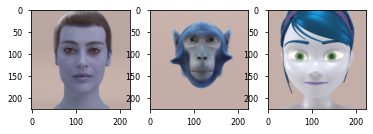

In [5]:
# plot images
plt.figure()
plt.subplot(1, 3, 1)
img1 = np.array(data[0][0] + 128)/256
img2 = np.array(data[0][1] + 128)/256
img3 = np.array(data[0][2] + 128)/256
img3[img3 > 1] = 1.0
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)

# predict with extraction pipeline

In [6]:
# predict v4 output
preds = v4_model.predict(data[0], verbose=1)
print("[TRAIN] shape prediction", np.shape(preds))

# get feature maps that mimic a semantic selection pipeline
# keep only highest IoU semantic score
eyebrow_preds = preds[..., best_eyebrow_IoU_ft]
print("shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
lips_preds = preds[..., best_lips_IoU_ft]
print("shape lips semantic feature selection", np.shape(lips_preds))
preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
print("[TRAIN] shape preds", np.shape(preds))

1/1 [==============================] - 0s 91ms/step
[TRAIN] shape prediction (3, 56, 56, 256)
shape eyebrow semantic feature selection (3, 56, 56, 2)
shape lips semantic feature selection (3, 56, 56, 16)
[TRAIN] shape preds (3, 56, 56, 18)


2022-07-08 10:59:41.645727: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-08 10:59:41.691783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# build RBF

In [7]:
rbf_template_hum = np.array([[[22, 25], [19, 22]], [[22, 25], [34, 37]], [[30, 33], [26, 31]]])  # louise
config['rbf_sigma'] = [3000, 3000, 2000]
patterns_hum = PatternFeatureSelection(config, template=rbf_template_hum)
rbf_template_monk = np.array([[[16, 19], [22, 25]], [[16, 19], [31, 34]], [[26, 29], [26, 31]]]) # Monkey
config['rbf_sigma'] = [2000, 2000, 2000]
patterns_monk = PatternFeatureSelection(config, template=rbf_template_monk)
rbf_template_cart = np.array([[[24, 27], [16, 19]], [[24, 27], [35, 38]], [[36, 39], [24, 29]]])  # Merry
config['rbf_sigma'] = [3000, 3000, 2000]
patterns_cart = PatternFeatureSelection(config, template=rbf_template_cart)

rbf_templates = [rbf_template_hum, rbf_template_monk, rbf_template_cart]
patterns = [patterns_hum, patterns_monk, patterns_cart]

shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)
shape img_norm (56, 56, 3)


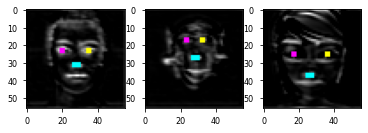

In [8]:
# show RBF on face
plt.figure()
for i in range(3):
    img = preds[i, ..., 0]
    img_norm = img / np.amax(img)
    img_norm = np.repeat(np.expand_dims(img_norm, axis=2), 3, axis=2)
    print("shape img_norm", np.shape(img_norm))

    img_norm[rbf_templates[i][0, 0, 0]:rbf_templates[i][0, 0, 1], rbf_templates[i][0, 1, 0]:rbf_templates[i][0, 1, 1]] = [1, 0, 1]
    img_norm[rbf_templates[i][1, 0, 0]:rbf_templates[i][1, 0, 1], rbf_templates[i][1, 1, 0]:rbf_templates[i][1, 1, 1]] = [1, 1, 0]
    img_norm[rbf_templates[i][2, 0, 0]:rbf_templates[i][2, 0, 1], rbf_templates[i][2, 1, 0]:rbf_templates[i][2, 1, 1]] = [0, 1, 1]

    plt.subplot(1, 3, i + 1)
    plt.imshow(img_norm, cmap='viridis')

# fit template

In [9]:
# fit templates
templates = []
for i in range(3):
    # template = patterns.fit(mask_template)
    _preds = np.expand_dims(preds[i], axis=0)
    template_preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[i]), axis=0)
    print("shape template preds", np.shape(template_preds))
    template = patterns[i].fit(template_preds)
    template[template < 0.25] = 0
    print("shape template", np.shape(template), np.amin(template), np.amax(template))
    templates.append(template)
print("shape templates", np.shape(templates))
templates = np.concatenate((templates[0], templates[1], templates[2]), axis=3)
print("shape templates", np.shape(templates))

shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape template preds (3, 1, 56, 56, 18)
[PATTERN] Fit pattern
shape template (1, 56, 56, 3) 0.0 1.0
shape templates (3, 1, 56, 56, 3)
shape templates (1, 56, 56, 9)


0 min max 0.0 1.0
1 min max 0.0 1.0
2 min max 0.0 1.0
3 min max 0.0 1.0
4 min max 0.0 1.0
5 min max 0.0 1.0
6 min max 0.0 1.0
7 min max 0.0 1.0
8 min max 0.0 1.0


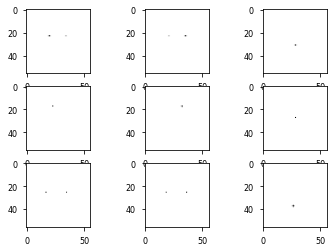

In [10]:
# plot template
plt.figure()
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i * 3 + j + 1)
        _template = templates[0, ..., i * 3 + j]
        print(i * 3 + j, "min max", np.amin(_template), np.amax(_template))
        plt.imshow(_template, cmap='Greys')

# get patches

In [11]:
# split in patches
def pred_to_patch(pred, patch_size=8):
    pred = np.expand_dims(pred, axis=[0, 3])
    patches = tf.image.extract_patches(
        images=pred,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    patches = patches.numpy()
    return patches

In [12]:
# test function pred_to_patch
patches = pred_to_patch(templates[0, ..., 0])
print("shape patches", np.shape(patches))

shape patches (1, 7, 7, 64)


In [13]:
def get_patches_centers(patches, patch_size=8, verbose=False):
    # compute center of activity for each patch
    centers = []
    max_patch = []
    for i in range(np.shape(patches)[1]):
        for j in range(np.shape(patches)[2]):
            # control if patches is not all zeros
            f_patch = patches[0, i, j]
            if np.sum(f_patch) > 0:
                CoA = compute_center_of_activity(np.reshape(f_patch, [patch_size, patch_size]), verbose=verbose)
                # compensate with patch positions
                centers.append([CoA[0] + j*patch_size, CoA[1] + i*patch_size])

                # keep maximum activity of the patch
                max_patch.append(np.amax(f_patch))

    return centers, max_patch

In [14]:
# test function get_patches_centers
centers, max_patch = get_patches_centers(patches)
print("shape centers", np.shape(centers))
print("max_patch", max_patch)

shape centers (2, 2)
max_patch [1.0, 0.403964835342019]


# Get activity from patches

In [15]:
def get_activity_from_patterns(preds, patterns, rbf_templates, threshold_val=0.25, do_plot=False):
    templates = []
    for p, pattern in enumerate(patterns):
        _preds = np.expand_dims(preds, axis=0)
        _preds = np.repeat(np.expand_dims(_preds, axis=0), len(rbf_templates[p]), axis=0)
        template = pattern.transform(_preds)
        template[template < threshold_val] = 0
        templates.append(template)

        if do_plot:
            plt.figure()
            plt.subplot(1, 3, 1)
            plt.imshow(template[0, ..., 0], cmap='Greys')
            plt.subplot(1, 3, 2)
            plt.imshow(template[0, ..., 1], cmap='Greys')
            plt.subplot(1, 3, 3)
            plt.imshow(template[0, ..., 2], cmap='Greys')


    # concatenate all templates
    _templates = np.array(templates[0])
    for i in range(1, len(patterns)):
        _templates = np.concatenate((_templates, templates[i]), axis=3)

    # get pos for each type
    pos_dict = {}
    n_entry = 0
    for i in range(np.shape(_templates)[-1]):
        patches = pred_to_patch(_templates[0, ..., i])
        positions, max_values = get_patches_centers(patches)

        for pos, max_val in zip(positions, max_values):
            pos_dict[n_entry] = {'type': i, 'pos': pos, 'max': max_val}
            n_entry += 1

    return pos_dict

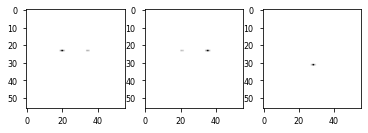

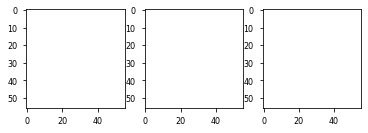

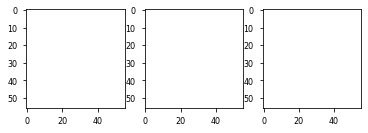

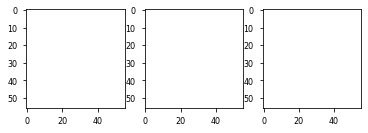

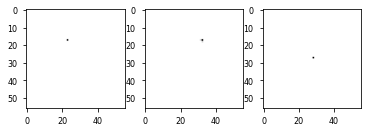

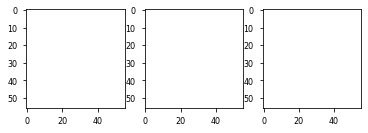

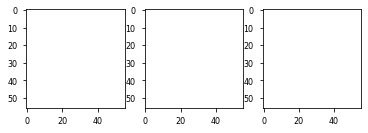

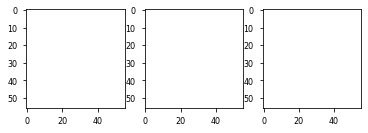

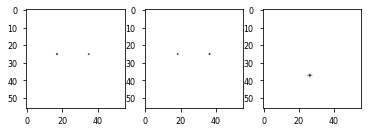

In [16]:
activities_dict = []
for i in range(3):
    activity_dict = get_activity_from_patterns(preds[i], patterns, rbf_templates, do_plot=True)
    activities_dict.append(activity_dict)

In [17]:
# display activities
for i in range(3):
    activity_dict = activities_dict[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [19.966002783255732, 22.99997534001919], 'max': 1.0}
{'type': 0, 'pos': [34.475426525860044, 22.99994182717735], 'max': 0.403964835342019}
{'type': 1, 'pos': [20.45619876840451, 22.99993346904182], 'max': 0.36614783330580697}
{'type': 1, 'pos': [34.986463522520104, 22.999975279613732], 'max': 1.0}
{'type': 2, 'pos': [27.95523490598333, 30.999972659279432], 'max': 1.0}

{'type': 3, 'pos': [22.999955200286717, 16.99999360004096], 'max': 1.0}
{'type': 4, 'pos': [30.999843511856202, 16.999977644550885], 'max': 0.28627726924667296}
{'type': 4, 'pos': [32.0, 17.21556937526991], 'max': 1.0}
{'type': 5, 'pos': [27.99997440016384, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
{'type': 6, 'pos': [34.99997756107178, 24.99999252035726], 'max': 0.8556494411518196}
{'type': 7, 'pos': [17.99998534290134, 24.99999267145067], 'max': 0.8732905802465699}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
{'

In [18]:
def max_pool_activity(activity_dict, dist_threshold=3, sorting='max', verbose=False):
    filt_dictionary = {}
    discarded_primer_idx = []

    for p_t in range(len(activity_dict)):
        for p_a in range(p_t + 1, len(activity_dict)):  # only upward diagonal
            # get primers
            p_target = activity_dict[p_t]
            p_agent = activity_dict[p_a]

            # retrieve positions
            pos_target = np.array(p_target["pos"])
            pos_agent = np.array(p_agent["pos"])
            distance = np.linalg.norm(pos_target - pos_agent)

            if verbose:
                print("distance", distance)

            # sort if distance is smaller than the threshold
            if distance < dist_threshold:
                # todo add possibility to sort by clustering the mean
                if sorting == 'max':
                    if p_target["max"] > p_agent["max"]:
                        discarded_primer_idx.append(p_a)
                    else:
                        discarded_primer_idx.append(p_t)

    if verbose:
        print("discarded primers")
        print(discarded_primer_idx)

    # append all non discarded primers
    n_primer = 0
    for p in activity_dict:
        if p not in discarded_primer_idx:
            primer = activity_dict[p]
            filt_dictionary[n_primer] = {"type": primer["type"], "pos": primer["pos"], "max": primer["max"]}
            n_primer += 1

    return filt_dictionary

In [19]:
activities_dict_max_pooled = []
for i in range(3):
    activity_dict = max_pool_activity(activities_dict[i])
    activities_dict_max_pooled.append(activity_dict)

In [20]:
# display activities
for i in range(3):
    activity_dict = activities_dict_max_pooled[i]
    for a in activity_dict:
        print(activity_dict[a])
    print()

{'type': 0, 'pos': [19.966002783255732, 22.99997534001919], 'max': 1.0}
{'type': 1, 'pos': [34.986463522520104, 22.999975279613732], 'max': 1.0}
{'type': 2, 'pos': [27.95523490598333, 30.999972659279432], 'max': 1.0}

{'type': 3, 'pos': [22.999955200286717, 16.99999360004096], 'max': 1.0}
{'type': 4, 'pos': [32.0, 17.21556937526991], 'max': 1.0}
{'type': 5, 'pos': [27.99997440016384, 26.999980800122877], 'max': 1.0}

{'type': 6, 'pos': [16.99999360004096, 24.99999360004096], 'max': 1.0}
{'type': 7, 'pos': [35.999974400163836, 24.99999360004096], 'max': 1.0}
{'type': 8, 'pos': [25.99452501418851, 37.02738211293368], 'max': 1.0}



# Get Type from activity

In [21]:
def get_type(activity_dict, verbose=False):
    types = [0, 0, 0]  # hum_type, monk_type, cart_type
    positions = []

    for i in activity_dict:
        if verbose:
            print(activity_dict[i])
        dict = activity_dict[i]

        # count types
        if dict['type'] in [0, 1, 2]:
            types[0] += 1
        elif dict['type'] in [3, 4, 5]:
            types[1] += 1
        elif dict['type'] in [6, 7, 8]:
            types[2] += 1

        # get positions of types
        if dict['type'] in [0, 3, 6]:
            right_eye_pos = dict['pos']
        elif dict['type'] in [1, 4, 7]:
            left_eye_pos = dict['pos']
        elif dict['type'] in [2, 5, 8]:
            nose_pos = dict['pos']

        positions.append(dict['pos'])

    if verbose:
        print("types:", types)
        print("positions")
        print(positions)
        print()

    bfs_type = np.argmax(types)
    mean_pos = np.mean(positions, axis=0)
    width = left_eye_pos[0] - right_eye_pos[0]
    height = nose_pos[1] - np.amin([left_eye_pos[1], right_eye_pos[1]])

    return bfs_type, mean_pos, [width, height]

In [22]:
types = ["human", "monkey", "cartoon"]
bfs_types = []
sizes = []
for i in range(3):
    bfs_type, pos, size = get_type(activities_dict_max_pooled[i])
    bfs_types.append(types[bfs_type])
    sizes.append(size)
    print("type:", types[bfs_type])
    print("pos:", pos)
    print("size:", size)
    print()

type: human
pos: [27.636 25.667]
size: [15.020460739264372, 7.9999973796657]

type: monkey
pos: [27.667 20.405]
size: [9.000044799713283, 9.999987200081918]

type: cartoon
pos: [26.331 29.009]
size: [18.999980800122877, 12.02738851289272]



# predict on test set

In [23]:
def predict_identity(preds, patterns, rbf_templates, verbose=False):
    activity_dict = get_activity_from_patterns(preds, patterns, rbf_templates)
    activity_dict = max_pool_activity(activity_dict)
    bfs_type, pos, size = get_type(activity_dict)

    if verbose:
        print("type:", types[bfs_type])
        print("pos:", pos)
        print("size:", size)
        print()

    return [bfs_type, pos, size]

In [24]:
# get all reference identities
test_data = load_data(config, train=False)
print("shape test data", np.shape(test_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 12/12 [00:00<00:00, 146.50it/s]

shape test data (12, 224, 224, 3)


In [25]:
# predict v4 output
test_preds = v4_model.predict(test_data[0], verbose=1)
print("[TEST] shape prediction", np.shape(test_preds))

# get feature maps that mimic a semantic selection pipeline
# keep only highest IoU semantic score
test_eyebrow_preds = test_preds[..., best_eyebrow_IoU_ft]
print("shape eyebrow semantic feature selection", np.shape(test_eyebrow_preds))
test_lips_preds = test_preds[..., best_lips_IoU_ft]
print("shape lips semantic feature selection", np.shape(test_lips_preds))
test_preds = np.concatenate((test_eyebrow_preds, test_lips_preds), axis=3)
print("[TEST] shape test_preds", np.shape(test_preds))

1/1 [==============================] - 0s 33ms/step
[TEST] shape prediction (12, 56, 56, 256)
shape eyebrow semantic feature selection (12, 56, 56, 2)
shape lips semantic feature selection (12, 56, 56, 16)
[TEST] shape test_preds (12, 56, 56, 18)


In [26]:
id_params = []
for pred in test_preds:
    id_param = predict_identity(pred, patterns, rbf_templates)
    id_params.append(id_param)

In [27]:
for id_param in id_params:
    print(id_param)

[0, array([27.366, 25.667]), [11.496484566370459, 8.000016928655857]]
[0, array([27.421, 25.667]), [13.363430541658026, 7.999991833549021]]
[0, array([27.811, 25.667]), [16.458663028750124, 8.000000604538688]]
[0, array([27.964, 25.667]), [17.775151038513776, 7.999998936731391]]
[1, array([27.667, 20.333]), [6.999936766021829, 9.999961091128224]]
[1, array([28.   , 20.333]), [8.0, 9.999987708219717]]
[1, array([27.67 , 20.395]), [9.810556861824523, 9.999984648185496]]
[1, array([27.545, 20.333]), [10.633852763374787, 9.999973271190317]]
[2, array([26.372, 28.953]), [15.000014446373818, 11.8585233622882]]
[2, array([26.334, 29.   ]), [16.9999940925375, 12.000429714281708]]
[2, array([26.334, 29.011]), [20.99996628284498, 12.033465555604625]]
[2, array([26.333, 29.012]), [23.00001375978319, 12.035161209347649]]


# get identity

In [28]:
# compute ratio, since this is the identity parameter!
for id_param in id_params:
    ref_size = sizes[id_param[0]]
    ratio = id_param[2][0] / ref_size[0]

    print("ratio:", ratio)


ratio: 0.7653882770931233
ratio: 0.889681799621847
ratio: 1.0957495455333275
ratio: 1.1833958589598041
ratio: 0.7777668802542881
ratio: 0.8888844642478734
ratio: 1.0900564475120236
ratio: 1.1815333145578955
ratio: 0.7894752423263928
ratio: 0.8947374353361218
ratio: 1.1052625001973249
ratio: 1.2105282632514263


## Test templates on all expressions

In [30]:
config["val_expression"] = ["full"]
test_data = load_data(config, train=False)
print("[LOAD] test_data loaded", np.shape(test_data[0]))

/Users/michaelstettler/PycharmProjects/BVS/BVS/utils/load_data.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(sub_df, ignore_index=True)
100%|██████████| 84/84 [00:00<00:00, 150.85it/s]

[LOAD] test_data loaded (84, 224, 224, 3)
